# Comparison of two monthly records at a list of locations

### Must run tg_processing, then alt_processing first

In [1]:
%load_ext autoreload
%autoreload 2

import copy

import cartopy.crs as xccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import scipy.stats
from scipy import spatial
import xarray as xr
import xesmf as xe

from scipy import signal

%matplotlib inline

panellabs=list(map(chr, range(97, 123)))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
def place_cbar(fig,pname,posin,xshift,yshift,width,height,titin):
    cbar_ax = fig.add_axes([posin.x0+xshift, posin.y0+yshift, width,height])
    cbar=fig.colorbar(pname, orientation='horizontal', cax=cbar_ax)
    cbar.ax.set_title(titin, rotation=0,size=14,weight='bold')

In [3]:
def plot_map_lg(ax,x,y,z,vmin,vmax,cmap):

    ax.set_global()

    ax.add_feature(cfeature.LAND.with_scale('110m'),color='.9')
    ax.coastlines()
    gl = ax.gridlines(crs=xccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')    
    gl.left_labels = True
    gl.right_labels = False 
    gl.top_labels = False 
    gl.bottom_labels = True
    XTEXT_SIZE = 14
    YTEXT_SIZE = XTEXT_SIZE
    # to facilitate text rotation at bottom edge, ...
    # text justification: 'ha':'right' is used to avoid clashing with map's boundary
    # default of 'ha' is center, often causes trouble when text rotation is not zero
    gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k', 'rotation':0, 'ha':'center'}
    gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}
    gl.xlocator = mticker.FixedLocator([-120,0,120])
    gl.ylocator = mticker.FixedLocator([-60,0,60])
    
    filled=plt.scatter(x=x, y=y, vmin=vmin, vmax=vmax,
            c=z, cmap=cmap,  #this is the changes            
            s=55,
            alpha=1,
            edgecolors= "grey",
            linewidth=1,            
            marker='o',
            zorder=3,
            transform=xccrs.PlateCarree()) ## Important
    # plt.rcParams["axes.edgecolor"] = "black"
    # plt.rcParams["axes.linewidth"] = 1
    return filled

In [4]:
import datetime as dt

def detrend_df(df):

    df_det=df.copy()
    days = pd.to_datetime(df.index).map(dt.datetime.toordinal)
    trend=[]
    
    for column in df:
        y=df[column]
        not_nan_ind = ~np.isnan(y)
        coefficients = np.polyfit(days[not_nan_ind],y[not_nan_ind],1)    
        fit=np.polyval(coefficients,days)
        df_det[column]=df[column]-fit
        trend.append(coefficients[0])
    return df_det, np.array(trend)*365.25*10

### bring in datasets and preprocess as necessary

In [5]:
tgs_in=pd.read_csv("real_tgs_in.csv")
tg_ibcorr = pd.read_pickle("tg_ts_93_18.pkl")
tg_ib = pd.read_pickle("tg_ib_93_18.pkl")
alt_ibcorr = pd.read_pickle("real_alt_ts.pkl")
fosi_ibcorr = pd.read_pickle("real_lr3_ts.pkl")
pd.set_option('display.max_rows', 10)

insert figure of regional points in ts1 and ts2

In [6]:
ts1=tg_ibcorr-tg_ibcorr.mean()
ts1.index=tg_ibcorr.index

ts2=alt_ibcorr-alt_ibcorr.mean()

ts3=fosi_ibcorr-fosi_ibcorr.mean()

In [7]:
# # GM REMOVAL FROM NASA PROVIDED MEASURES IPYNB IN MEASURES DIRECTORY
# gmsl = pd.read_pickle("measures_gmsl.pkl")
# gmsl=gmsl/10
# gmsl.index=tg_ibcorr.index
# gmsl_df=tg_ibcorr*0
# gmsl_df=gmsl_df.add(gmsl, axis=0)

### decompose TSs

In [8]:
focustg=['10']

In [9]:
ts2_det,ts2_trend = detrend_df(ts2)
ts2_desea=ts2_det.groupby(ts2_det.index.month).transform(lambda x: x-x.mean())
ts2_mean_sea=ts2_det-ts2_desea

In [10]:
ts1_det,ts1_trend = detrend_df(ts1)
ts1_desea=ts1_det.groupby(ts1_det.index.month).transform(lambda x: x-x.mean())
ts1_desea.interpolate(axis=0,inplace=True,limit=10, limit_direction='both')
ts1_mean_sea=ts1_det-ts1_desea

In [11]:
ts3_det,ts3_trend = detrend_df(ts3)
ts3_desea=ts3_det.groupby(ts3_det.index.month).transform(lambda x: x-x.mean())
ts3_mean_sea=ts3_det-ts3_desea

### plots

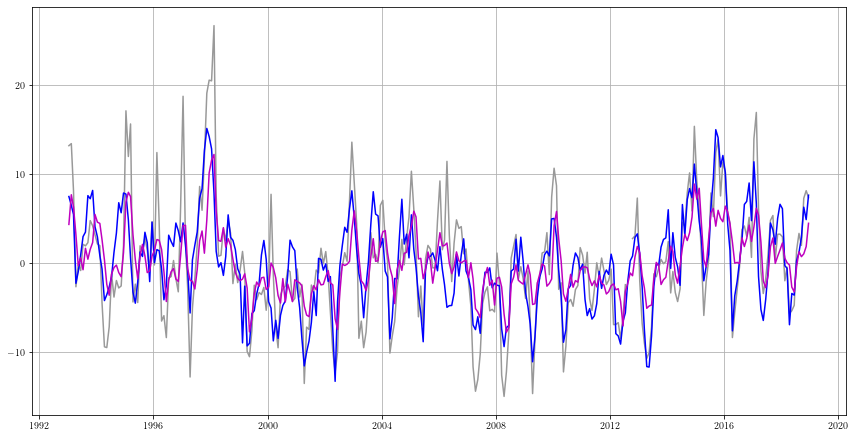

In [12]:
fig=plt.figure(figsize=(12,12), tight_layout=True)

ax = plt.subplot2grid((2,1),(0,0), colspan=1, rowspan=1)
l1=ts1_det[focustg]
ax.plot(l1,color='.6',ls='-',label='line1');
l1=ts2_det[focustg]
ax.plot(l1,color='b',ls='-',label='line1');
l1=ts3_det[focustg]
ax.plot(l1,color='m',ls='-',label='line1');
plt.grid()

/glade/scratch/clittle/ipykernel_232782/4056737388.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


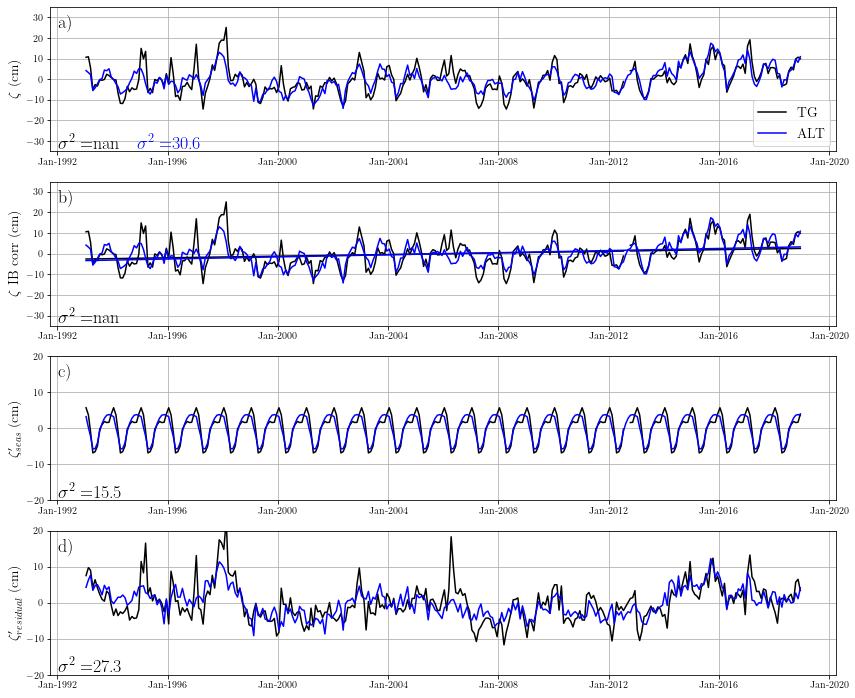

In [13]:
import matplotlib.dates as mdates

mdates.MonthLocator(bymonthday=15)

fig=plt.figure(figsize=(12,12), tight_layout=True)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

ax = plt.subplot2grid((5,1),(0,0), colspan=1, rowspan=1)
    
l1=ts1[focustg]

ax.plot(l1, color='k',ls='-',label='line1');
   
l2=ts2[focustg]

ax.plot(l2, color='b',ls='-',label='line1');

# ax.text(.3,.1, '$\sigma^2=$'+str('{0:.1f}'.format(np.std(l1)**2))+', '+str('{0:.1f}'.format(np.std(l2)**2))+', '+str('{0:.1f}'.format(np.std(l3)**2)),
#         transform=ax.transAxes, fontsize=18, weight='bold',color='.6')

ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format((np.std(np.asarray(l1)))**2)),
        transform=ax.transAxes, fontsize=18, weight='bold',color='k')
ax.text(.11,.02, '$\sigma^2=$'+str('{0:.1f}'.format((np.std(np.asarray(l2)))**2)),
        transform=ax.transAxes, fontsize=18, weight='bold',color='b')

ax.legend([],     # The line objects
           labels=["TG", "ALT", "IB"],   # The labels for each line
           loc="lower right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=14,# Title for the legend
           )

plt.ylabel("$\zeta$ (cm)",fontsize=14)
plt.xlabel("",fontsize=14)
ax.text(.01,.85, panellabs[0]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')
    

plt.ylim([-35,35])
plt.grid()

ax = plt.subplot2grid((5,1),(1,0), colspan=1, rowspan=1)

l1=ts1[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l3=ts1[focustg]-ts1_det[focustg]
ax.plot(l3, color='k',ls='-',label='line1');

l2=ts2[focustg]
ax.plot(l2, color='b',ls='-',label='line1');

l4=ts2[focustg]-ts2_det[focustg]
ax.plot(l4, color='b',ls='-',label='line1');

ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format((np.std(np.asarray(l1)))**2)),
        transform=ax.transAxes, fontsize=18, weight='bold',color='k')

plt.ylabel("$\zeta$ IB corr (cm)",fontsize=14)
plt.xlabel("",fontsize=14)
ax.text(.01,.85, panellabs[1]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

plt.ylim([-35,35])
plt.grid()

ax = plt.subplot2grid((5,1),(2,0), colspan=1, rowspan=1)

l1=ts1_mean_sea[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l2=ts2_mean_sea[focustg]
ax.plot(l2, color='b',ls='-',label='line1');

plt.ylim([-20,20])
plt.grid()
plt.xlabel("",fontsize=14)
plt.ylabel("$\zeta^{\prime}_{seas}$ (cm)",fontsize=14)
ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format(np.nanstd(np.asarray(l1))**2)), transform=ax.transAxes, fontsize=18, weight='bold',color='k')
ax.text(.01,.85, panellabs[2]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

    
ax = plt.subplot2grid((5,1),(3,0), colspan=1, rowspan=1)

l1=ts1_desea[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l2=ts2_desea[focustg]
ax.plot(l2, color='b',ls='-',label='line1');


plt.ylim([-20,20])
plt.grid()
plt.xlabel("",fontsize=14)
plt.ylabel("$\zeta^{\prime}_{residual}$ (cm)",fontsize=14)
ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format(np.nanstd(np.asarray(l1))**2)), transform=ax.transAxes, fontsize=18, weight='bold',color='k')
ax.text(.01,.85, panellabs[3]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')
    
# plt.savefig('f2.pdf', dpi=None, 
#         format="pdf",
#         pad_inches = 0,
#         bbox_inches='tight'
#            )

Text(-180, 80, 'a) ')

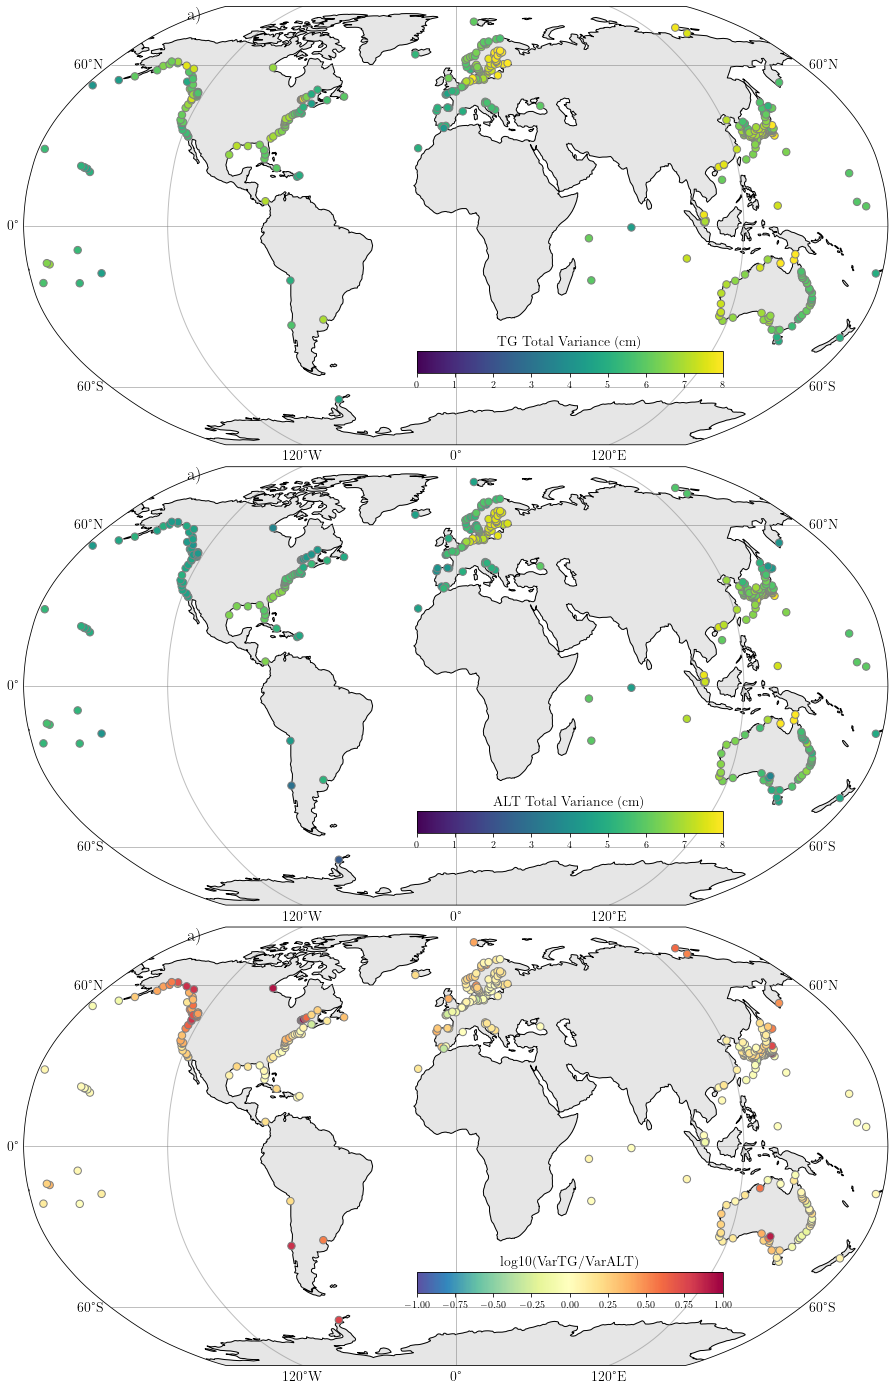

In [14]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)
tt=tgs_in.set_index('name')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Total Variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG Total Variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarTG/VarALT)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

Text(-180, 80, 'a) ')

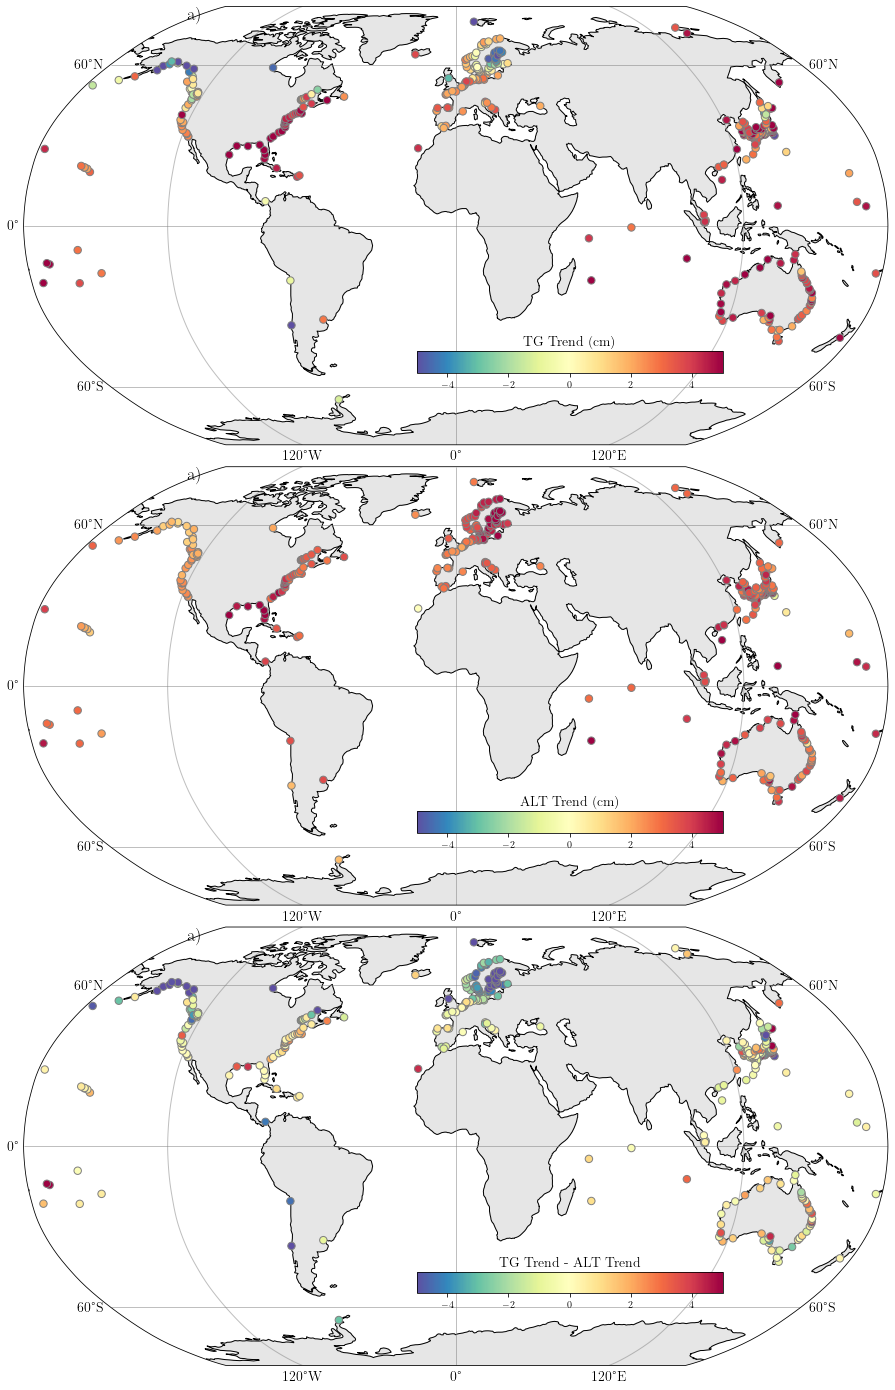

In [15]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)
tt=tgs_in.set_index('name')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=-5
vmax=5
cmap='Spectral_r'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=ts2_trend
# z=z.to_frame()
# z.columns=['cycle3']
# z['cycle2']=ts2_trend2
# z['cycle4']=ts2_trend4
# z=z.mean(axis=1)
z1=z

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Trend (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=ts1_trend
# z=z.to_frame()
# z.columns=['cycle3']
# z['cycle2']=ts1_trend2
# z['cycle4']=ts1_trend4
# z=z.mean(axis=1)
z2=z

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG Trend (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=z2-z1

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG Trend - ALT Trend')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

Text(-180, 80, 'a) ')

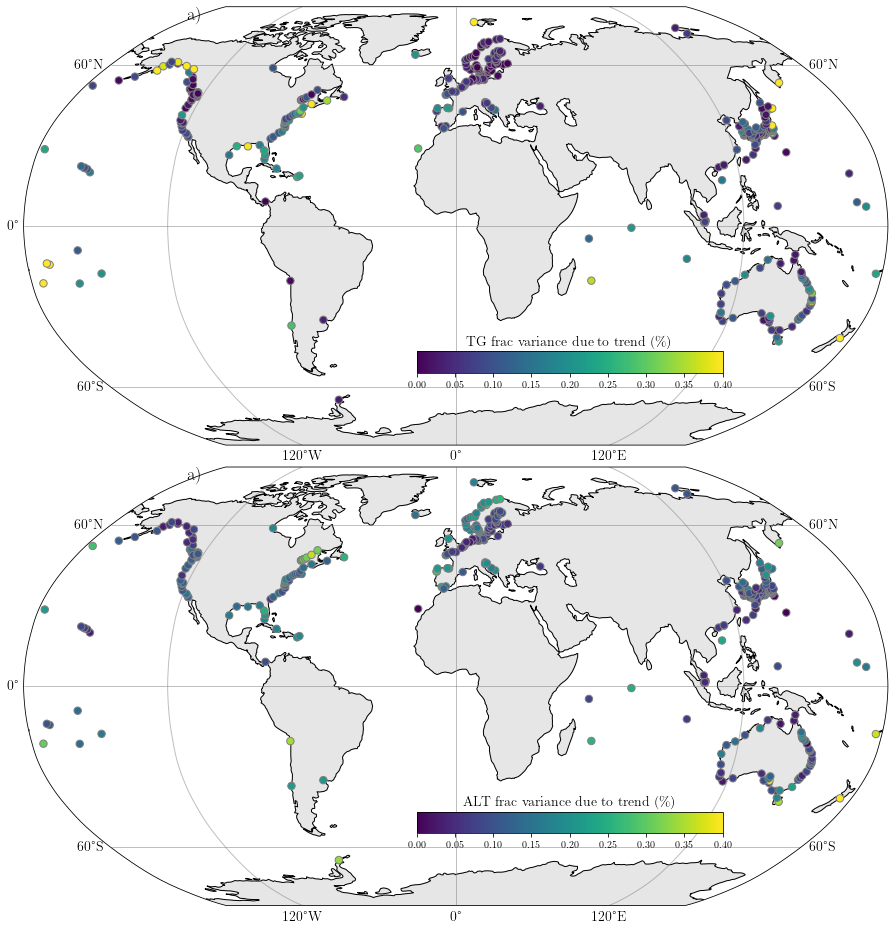

In [16]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)
tt=tgs_in.set_index('name')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=.4
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=1-((np.var(ts2_det))/((np.var(ts2))))

# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT frac variance due to trend (\%)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=1-((np.var(ts1_det))/((np.var(ts1))))

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG frac variance due to trend (\%)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

Text(-180, 80, 'a) ')

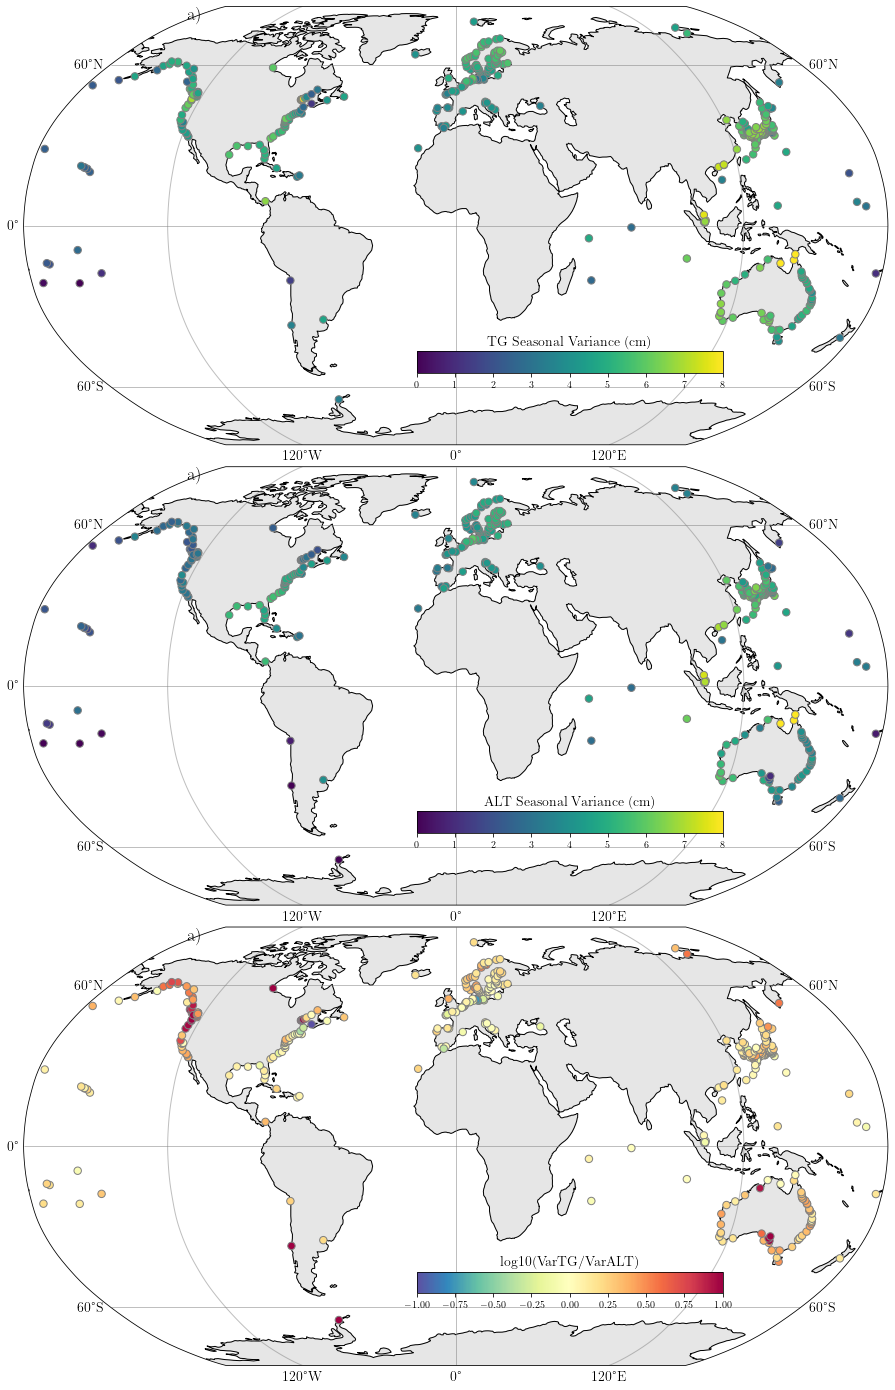

In [17]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)
tt=tgs_in.set_index('name')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2_mean_sea)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Seasonal Variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1_mean_sea)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG Seasonal Variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarTG/VarALT)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

Text(-180, 80, 'a) ')

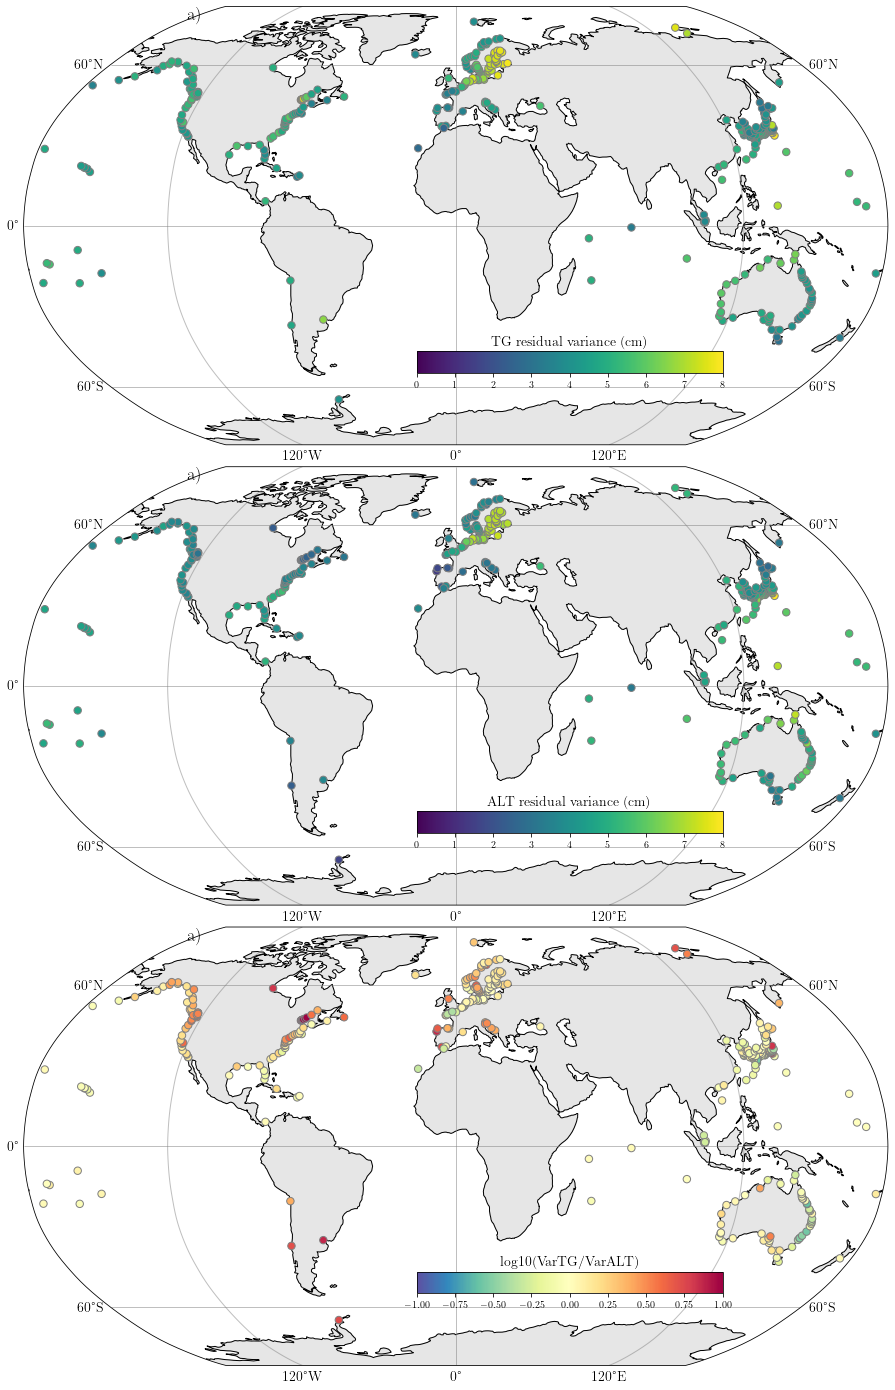

In [18]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)
tt=tgs_in.set_index('name')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2_desea)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT residual variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1_desea)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'TG residual variance (cm)')
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarTG/VarALT)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

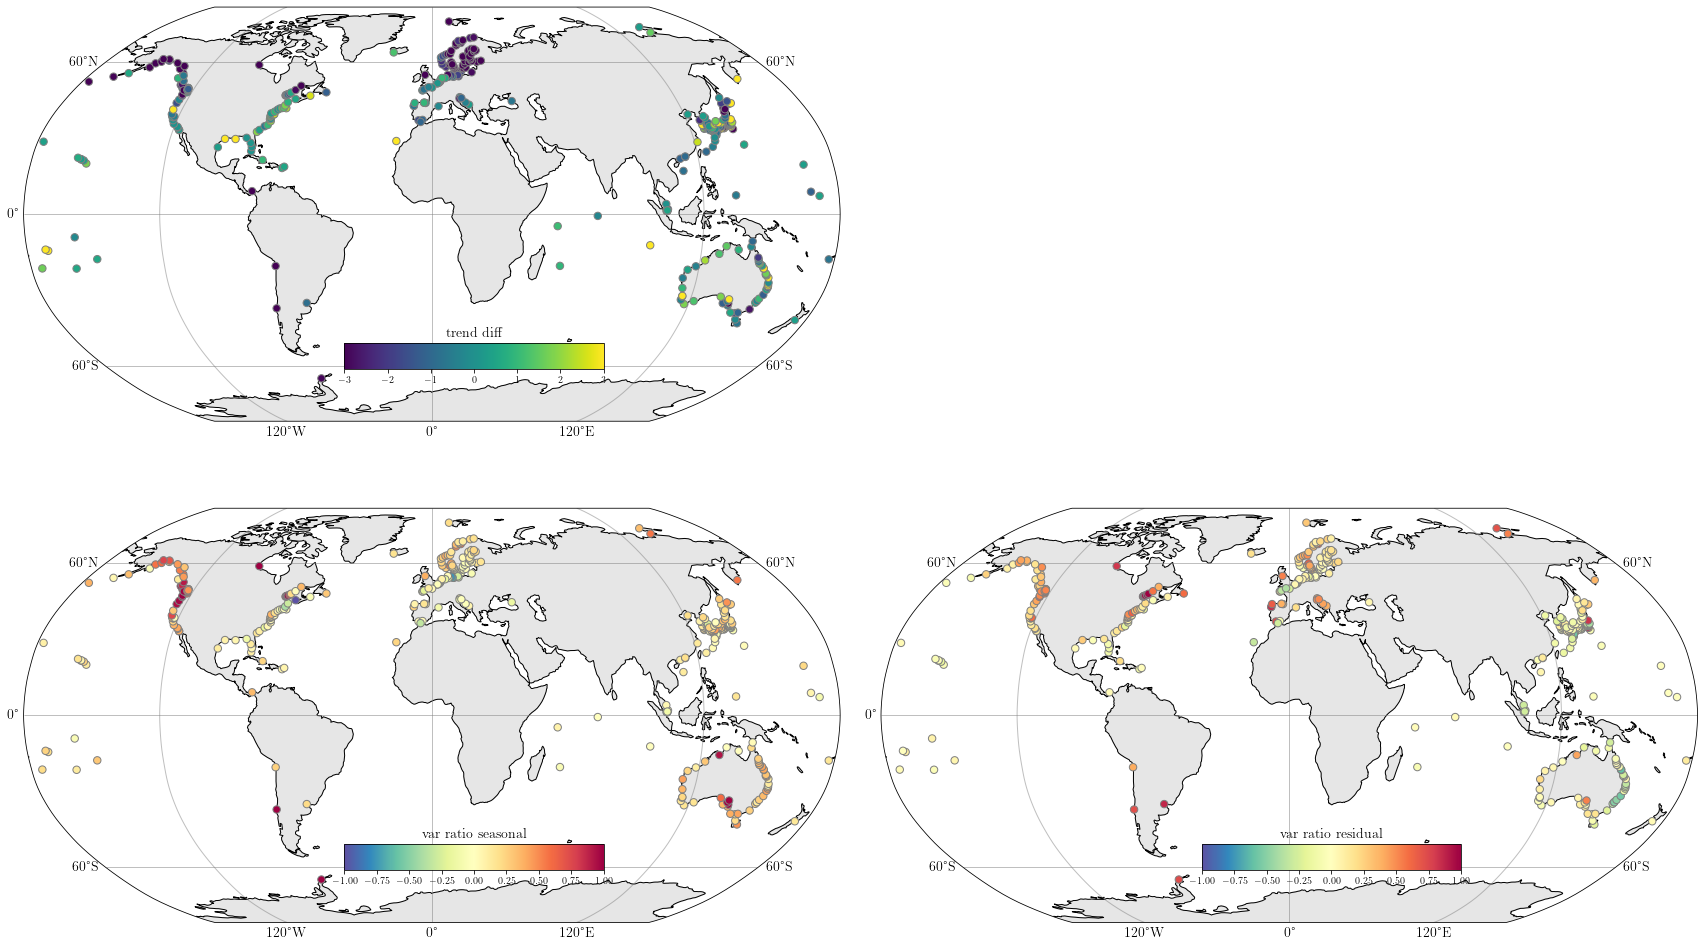

In [19]:
fig = plt.figure(figsize=(30,18))#, tight_layout=True)
tt=tgs_in.set_index('name')

# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.07
yshift=.065
cb_w=.12
cb_h=.02
cmap='coolwarm'

cmap='viridis'

z=ts1_trend-ts2_trend
ax = fig.add_subplot(2,2,1, projection=xccrs.Robinson())
vmin = -3
vmax = 3
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'trend diff')

cmap='Spectral_r'
z=np.log10(np.var(ts1_mean_sea)/np.var(ts2_mean_sea))

ax = fig.add_subplot(2,2,3, projection=xccrs.Robinson())
vmin = -1
vmax = 1
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio seasonal')

# z=np.log10(np.var(ts1_hp3)/np.var(ts2_hp3))

# ax = fig.add_subplot(2,2,2, projection=xccrs.Robinson())
# pos = ax.get_position() # get the original position 

# filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
# place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio sub-seasonal')

z=np.log10(np.var(ts1_desea)/np.var(ts2_desea))

ax = fig.add_subplot(2,2,4, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio residual')